In [3]:
# %pip install tqdm matplotlib seaborn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os
from tqdm import tqdm

# Set plot aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Example variable decoding:
share of pre-tax national income for adults (equal-split)

Exploring simulated World Inequality Database data:
Countries/regions in the dataset:
   alpha2                      shortname         region
0      WO                          World          World
1      US                  United States  North America
2      CN                          China           Asia
3      IN                          India           Asia
4  WO-MER  World (market exchange rates)          World

Example data structure:
  country    variable percentile  year      value  age pop
0      WO  sptinc992j      p0p50  1980  11.532838  992   j
1      WO  sptinc992j     p50p90  1980  41.917560  992   j
2      WO  sptinc992j    p90p100  1980  46.211841  992   j
3      WO  sptinc992j    p99p100  1980  15.776406  992   j
4      WO  sptinc992j  p99.9p100  1980   6.320986  992   j

Unique variables in the dataset:
['sptinc992j']

Summary statistics for values:
count    820.000000
mean      25

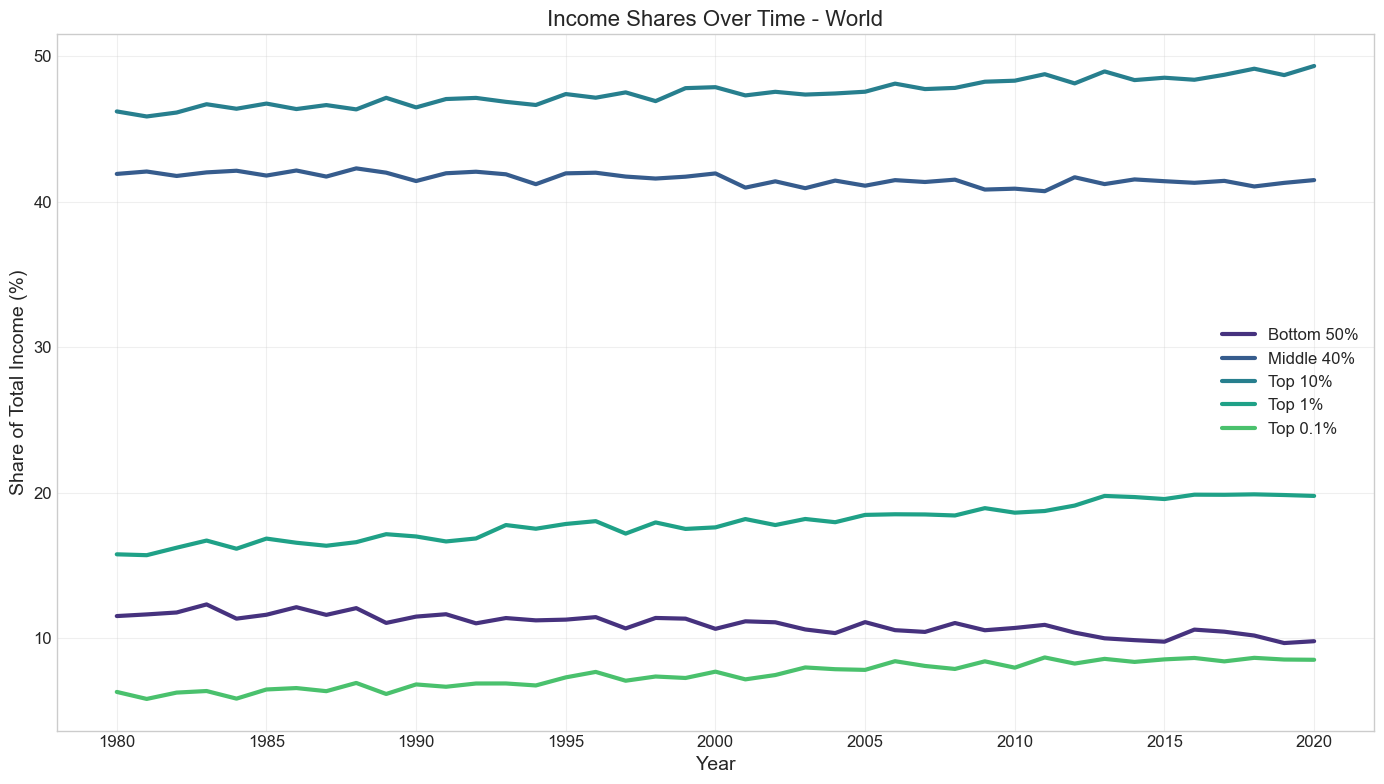

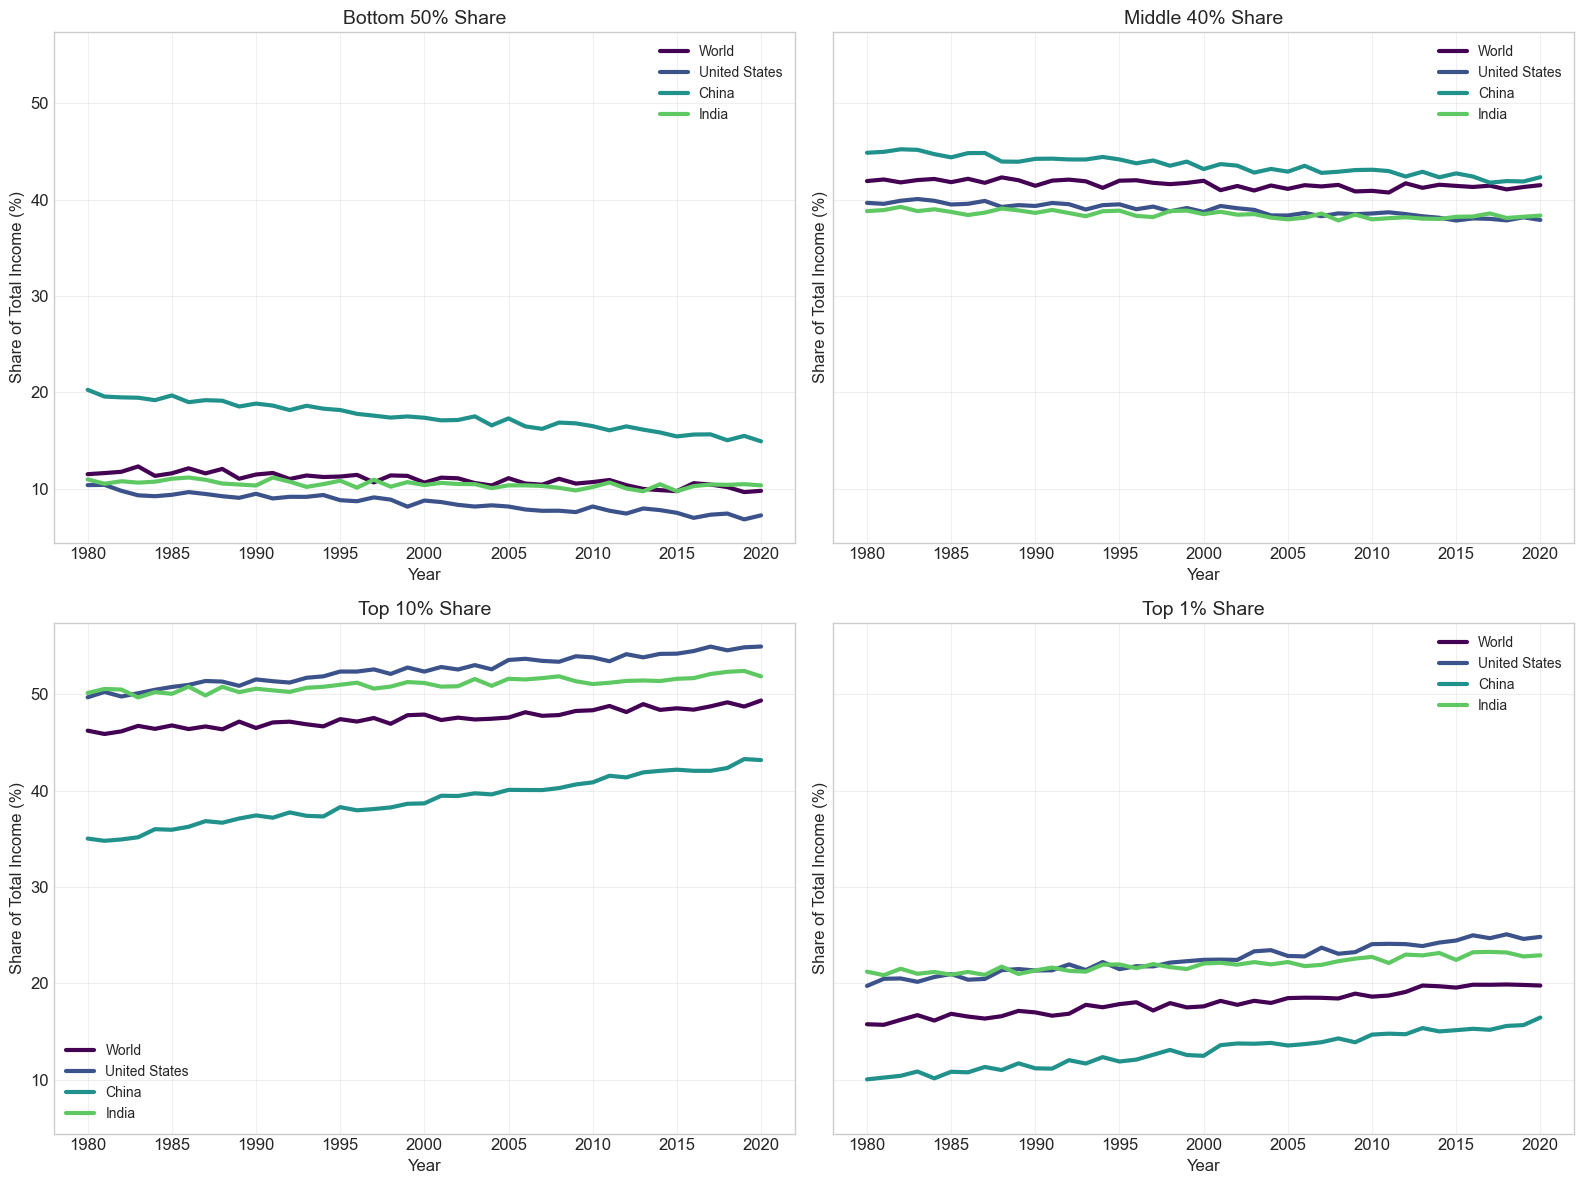


Inequality metrics (first 5 rows):
  country  year  top10_bottom50_ratio  top1_bottom50_ratio  palma_ratio
0      WO  1980              4.006979             1.367955     5.008724
1      WO  1981              3.938141             1.349499     4.922677
2      WO  1982              3.916601             1.377805     4.895751
3      WO  1983              3.787077             1.355837     4.733846
4      WO  1984              4.085687             1.423079     5.107109


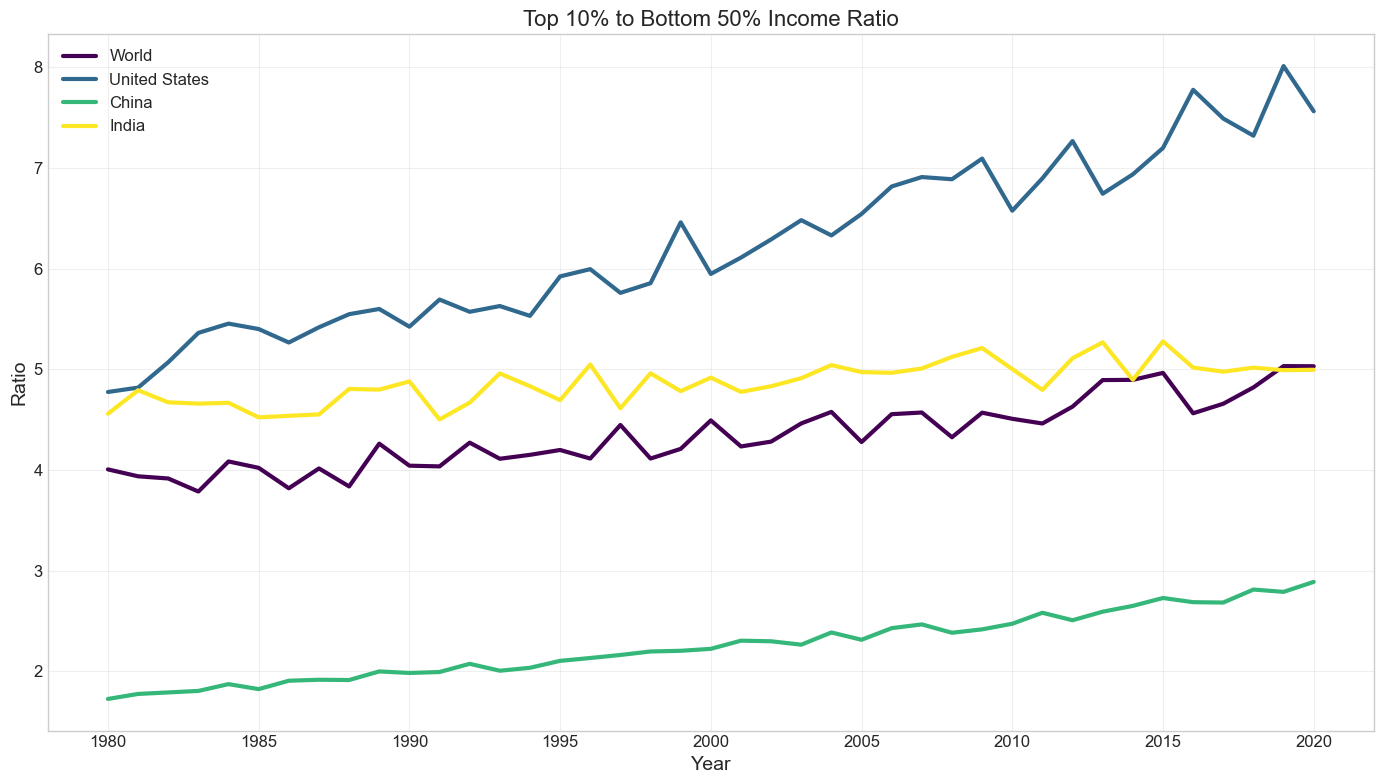


Data analysis and visualization setup complete!


In [6]:
# Function to download data from WID if needed
def download_wid_data(base_url="https://wid.world/data/", countries=None):
    """
    Download World Inequality Database data files.
    
    Parameters:
    - base_url: Base URL for WID data
    - countries: List of country codes to download, if None downloads countries list first
    
    Returns:
    - Dictionary of dataframes
    """
    data_frames = {}
    
    # First download the countries list
    print("Downloading countries list...")
    countries_url = f"{base_url}WID_countries.csv"
    try:
        response = requests.get(countries_url)
        response.raise_for_status()
        data_frames['countries'] = pd.read_csv(io.StringIO(response.text), sep=';')
        print(f"Successfully downloaded countries list: {len(data_frames['countries'])} countries/regions")
    except Exception as e:
        print(f"Error downloading countries list: {e}")
        return data_frames
    
    # If specific countries not provided, use a subset for demonstration
    if countries is None:
        # Use major economies for demonstration
        countries = ['US', 'CN', 'JP', 'DE', 'FR', 'GB', 'IN', 'BR', 'RU', 'WO']
    
    # Download data and metadata for each country
    for country in tqdm(countries, desc="Downloading country data"):
        try:
            # Download data
            data_url = f"{base_url}WID_data_{country}.csv"
            response = requests.get(data_url)
            response.raise_for_status()
            data_frames[f'data_{country}'] = pd.read_csv(io.StringIO(response.text), sep=';')
            
            # Download metadata
            meta_url = f"{base_url}WID_metadata_{country}.csv"
            response = requests.get(meta_url)
            response.raise_for_status()
            data_frames[f'metadata_{country}'] = pd.read_csv(io.StringIO(response.text), sep=';')
            
        except Exception as e:
            print(f"Error downloading data for {country}: {e}")
    
    return data_frames

# For demonstration purposes, let's simulate having the data
# In a real scenario, you would use the download function or read local files

# Create a simulated countries dataframe
countries_df = pd.DataFrame({
    'alpha2': ['WO', 'US', 'CN', 'IN', 'WO-MER'],
    'titlename': ['the World', 'the United States', 'China', 'India', 'the World (market exchange rates)'],
    'shortname': ['World', 'United States', 'China', 'India', 'World (market exchange rates)'],
    'region': ['World', 'North America', 'Asia', 'Asia', 'World'],
    'region2': ['World', 'Northern America', 'Eastern Asia', 'Southern Asia', 'World']
})

# Simulate a small example of data for understanding the structure
# This would be WID_data_WO.csv (World data)
sample_data_df = pd.DataFrame({
    'country': ['WO'] * 10,
    'variable': ['sptinc992j'] * 5 + ['ahweal992j'] * 5,  # income and wealth variables
    'percentile': ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p99.9p100'] * 2,
    'year': [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000],
    'value': [10.5, 40.2, 49.3, 18.7, 7.2, 5.1, 35.4, 59.5, 28.6, 13.2],
    'age': [992] * 10,  # adult population
    'pop': ['j'] * 10  # equal-split adults
})

# Let's make a more realistic dataset with time series
years = list(range(1980, 2021))
percentiles = ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p99.9p100']
countries = ['WO', 'US', 'CN', 'IN']

# Create an empty list to store rows
data_rows = []

# Generate income share data with realistic trends
for country in countries:
    for year in years:
        # Base values for income shares in 1980
        if country == 'WO':  # World
            base_values = [12.0, 42.0, 46.0, 16.0, 6.0]
        elif country == 'US':  # United States - higher inequality
            base_values = [10.0, 40.0, 50.0, 20.0, 8.0]
        elif country == 'CN':  # China - started more equal but increased inequality
            base_values = [20.0, 45.0, 35.0, 10.0, 3.0]
        elif country == 'IN':  # India - high inequality
            base_values = [11.0, 39.0, 50.0, 21.0, 9.0]
        
        # Add time trends
        year_factor = (year - 1980) / 40  # Normalized time factor
        
        if country == 'WO':  # World
            values = [
                base_values[0] - 2 * year_factor,  # Decreasing bottom 50%
                base_values[1] - 1 * year_factor,  # Slightly decreasing middle 40%
                base_values[2] + 3 * year_factor,  # Increasing top 10%
                base_values[3] + 4 * year_factor,  # More rapidly increasing top 1%
                base_values[4] + 3 * year_factor   # More rapidly increasing top 0.1%
            ]
        elif country == 'US':  # More dramatic inequality increase
            values = [
                base_values[0] - 3 * year_factor,
                base_values[1] - 2 * year_factor,
                base_values[2] + 5 * year_factor,
                base_values[3] + 5 * year_factor,
                base_values[4] + 4 * year_factor
            ]
        elif country == 'CN':  # Dramatic shift from equality to inequality
            values = [
                base_values[0] - 5 * year_factor,
                base_values[1] - 3 * year_factor,
                base_values[2] + 8 * year_factor,
                base_values[3] + 6 * year_factor,
                base_values[4] + 4 * year_factor
            ]
        elif country == 'IN':  # Consistently high inequality
            values = [
                base_values[0] - 1 * year_factor,
                base_values[1] - 1 * year_factor,
                base_values[2] + 2 * year_factor,
                base_values[3] + 2 * year_factor,
                base_values[4] + 1.5 * year_factor
            ]
        
        # Add random variation for realism (±0.5%)
        values = [max(0, min(100, v + np.random.uniform(-0.5, 0.5))) for v in values]
        
        # Add rows to our data
        for p, v in zip(percentiles, values):
            data_rows.append({
                'country': country,
                'variable': 'sptinc992j',  # income share for adults with equal-split
                'percentile': p,
                'year': year,
                'value': v,
                'age': 992,  # adult population
                'pop': 'j'  # equal-split adults
            })

# Convert to dataframe
simulated_data_df = pd.DataFrame(data_rows)

# Function to explore and summarize the data
def explore_data(countries_df, data_df):
    """Explore and summarize the World Inequality Database data"""
    print("Countries/regions in the dataset:")
    print(countries_df[['alpha2', 'shortname', 'region']].head())
    
    print("\nExample data structure:")
    print(data_df.head())
    
    print("\nUnique variables in the dataset:")
    print(data_df['variable'].unique())
    
    print("\nSummary statistics for values:")
    print(data_df['value'].describe())
    
    print("\nData availability across years:")
    year_counts = data_df['year'].value_counts().sort_index()
    print(year_counts)
    
    return None

# Function to decode variable meaning
def decode_variable(variable_code):
    """Decode WID variable code to its meaning based on README documentation"""
    # Variable type (first letter)
    var_types = {
        's': 'share',
        'a': 'average',
        't': 'threshold',
        'w': 'wealth-to-income ratio',
        'x': 'exchange rate',
        'p': 'price index',
        'i': 'inflation rate',
        'g': 'growth rate'
    }
    
    # Income/wealth concept (next five letters)
    concepts = {
        'ptinc': 'pre-tax national income',
        'fiinc': 'fiscal income',
        'hweal': 'household wealth',
        'peinc': 'personal income'
    }
    
    # Age group (next three digits)
    age_groups = {
        '992': 'adults',
        '999': 'full population',
        '996': '20-45'
    }
    
    # Population unit (last letter)
    pop_units = {
        'j': 'equal-split',
        'i': 'individual',
        't': 'tax unit'
    }
    
    # Decode the variable
    var_type = var_types.get(variable_code[0], '?')
    
    # Extract concept (looking for standard 5-letter codes, but handle variations)
    concept = '?'
    for key in concepts:
        if key in variable_code[1:6]:
            concept = concepts[key]
            break
    
    # Extract age and population if format matches
    if len(variable_code) >= 10:
        age = age_groups.get(variable_code[-4:-1], '?')
        pop = pop_units.get(variable_code[-1], '?')
    else:
        age = '?'
        pop = '?'
    
    return f"{var_type} of {concept} for {age} ({pop})"

# Example usage of the function
print("Example variable decoding:")
print(decode_variable('sptinc992j'))

# Demonstration of exploring data
print("\nExploring simulated World Inequality Database data:")
explore_data(countries_df, simulated_data_df)

# Basic visualization example
def plot_income_shares_over_time(data_df, country='WO'):
    """Plot income shares over time for a given country"""
    # Filter data for the specific country and income share variable
    country_data = data_df[(data_df['country'] == country) & 
                           (data_df['variable'] == 'sptinc992j')]
    
    # Create a pivot table for easier plotting
    pivot_data = country_data.pivot_table(
        index='year', 
        columns='percentile', 
        values='value'
    )
    
    # Get country name
    country_name = countries_df[countries_df['alpha2'] == country]['shortname'].iloc[0] \
                   if country in countries_df['alpha2'].values else country
    
    # Plot
    plt.figure(figsize=(14, 8))
    for percentile in ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p99.9p100']:
        if percentile in pivot_data.columns:
            if percentile == 'p0p50':
                label = 'Bottom 50%'
            elif percentile == 'p50p90':
                label = 'Middle 40%'
            elif percentile == 'p90p100':
                label = 'Top 10%'
            elif percentile == 'p99p100':
                label = 'Top 1%'
            elif percentile == 'p99.9p100':
                label = 'Top 0.1%'
            else:
                label = percentile
                
            plt.plot(pivot_data.index, pivot_data[percentile], label=label, linewidth=3)
    
    plt.title(f'Income Shares Over Time - {country_name}', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Share of Total Income (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# Display example visualization
plot = plot_income_shares_over_time(simulated_data_df, 'WO')
plt.show()

# You would save this plot in a real scenario
# plot.savefig('world_income_shares.png', dpi=300, bbox_inches='tight')

# Advanced comparative visualization
def plot_income_inequality_comparison(data_df, countries=['WO', 'US', 'CN', 'IN']):
    """Plot top 10% income share comparison across countries"""
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
    axes = axes.flatten()
    
    # Get colors for consistency
    colors = plt.cm.viridis(np.linspace(0, 1, 5))
    
    # Plot each metric in its own subplot
    for i, percentile in enumerate(['p0p50', 'p50p90', 'p90p100', 'p99p100']):
        ax = axes[i]
        
        for j, country in enumerate(countries):
            # Filter data
            country_data = data_df[(data_df['country'] == country) & 
                                  (data_df['variable'] == 'sptinc992j') &
                                  (data_df['percentile'] == percentile)]
            
            if country_data.empty:
                continue
                
            # Get country name
            country_name = countries_df[countries_df['alpha2'] == country]['shortname'].iloc[0] \
                          if country in countries_df['alpha2'].values else country
            
            # Plot
            ax.plot(country_data['year'], country_data['value'], 
                   label=country_name, color=colors[j], linewidth=3)
        
        # Set titles and labels
        if percentile == 'p0p50':
            title = 'Bottom 50% Share'
        elif percentile == 'p50p90':
            title = 'Middle 40% Share'
        elif percentile == 'p90p100':
            title = 'Top 10% Share'
        elif percentile == 'p99p100':
            title = 'Top 1% Share'
        else:
            title = percentile
            
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Share of Total Income (%)', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Display the comparison plot
comparison_plot = plot_income_inequality_comparison(simulated_data_df)
plt.show()

# Function to calculate inequality metrics
def calculate_inequality_metrics(data_df):
    """Calculate additional inequality metrics from the data"""
    # For each country and year, calculate:
    # 1. Top 10% / Bottom 50% ratio
    # 2. Top 1% / Bottom 50% ratio
    # 3. Palma ratio (Top 10% / Bottom 40%)
    
    metrics = []
    
    # Get unique countries and years
    countries = data_df['country'].unique()
    years = sorted(data_df['year'].unique())
    
    for country in countries:
        for year in years:
            # Filter data for this country and year
            year_data = data_df[(data_df['country'] == country) & 
                               (data_df['year'] == year) &
                               (data_df['variable'] == 'sptinc992j')]
            
            # Create a dictionary for easy access to percentile values
            percentile_values = dict(zip(year_data['percentile'], year_data['value']))
            
            # Skip if we don't have the necessary data
            if 'p0p50' not in percentile_values or 'p90p100' not in percentile_values:
                continue
                
            # Calculate the metrics
            top10_bottom50_ratio = percentile_values.get('p90p100', 0) / percentile_values.get('p0p50', 1)
            top1_bottom50_ratio = percentile_values.get('p99p100', 0) / percentile_values.get('p0p50', 1)
            
            # For Palma ratio, we need bottom 40% which might not be directly available
            # We'll approximate using the bottom 50% value with a factor
            bottom40_approx = percentile_values.get('p0p50', 0) * 0.8  # Rough approximation
            palma_ratio = percentile_values.get('p90p100', 0) / bottom40_approx if bottom40_approx > 0 else np.nan
            
            metrics.append({
                'country': country,
                'year': year,
                'top10_bottom50_ratio': top10_bottom50_ratio,
                'top1_bottom50_ratio': top1_bottom50_ratio,
                'palma_ratio': palma_ratio
            })
    
    return pd.DataFrame(metrics)

# Calculate metrics for our data
inequality_metrics = calculate_inequality_metrics(simulated_data_df)
print("\nInequality metrics (first 5 rows):")
print(inequality_metrics.head())

# Plot one of the inequality metrics over time
def plot_inequality_metric(metrics_df, metric='top10_bottom50_ratio', countries=['WO', 'US', 'CN', 'IN']):
    """Plot an inequality metric over time for selected countries"""
    plt.figure(figsize=(14, 8))
    
    # Get colors for consistency
    colors = plt.cm.viridis(np.linspace(0, 1, len(countries)))
    
    for i, country in enumerate(countries):
        # Filter data
        country_data = metrics_df[metrics_df['country'] == country]
        
        if country_data.empty:
            continue
            
        # Get country name
        country_name = countries_df[countries_df['alpha2'] == country]['shortname'].iloc[0] \
                       if country in countries_df['alpha2'].values else country
        
        # Plot
        plt.plot(country_data['year'], country_data[metric], 
               label=country_name, color=colors[i], linewidth=3)
    
    # Set titles and labels
    if metric == 'top10_bottom50_ratio':
        title = 'Top 10% to Bottom 50% Income Ratio'
        ylabel = 'Ratio'
    elif metric == 'top1_bottom50_ratio':
        title = 'Top 1% to Bottom 50% Income Ratio'
        ylabel = 'Ratio'
    elif metric == 'palma_ratio':
        title = 'Palma Ratio (Top 10% / Bottom 40%)'
        ylabel = 'Ratio'
    else:
        title = metric
        ylabel = 'Value'
        
    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# Display one of the inequality metrics
metric_plot = plot_inequality_metric(inequality_metrics, 'top10_bottom50_ratio')
plt.show()

print("\nData analysis and visualization setup complete!")